In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
max_degree=20 # 多项式的最大阶数
n_train,n_test=100,100 # 训练和测试数据集大小
true_w=np.zeros(max_degree) #分配大量空间
true_w[0:4]=np.array([5,1.2,-3.4,5.6])
# print(true_w)
features=np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features=np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    # print(i)
    poly_features[:,i] /=math.gamma(i+1)#gamma(n)=(n-1)!
    # print(poly_features[:,i])
# labels的维度:(n_train+n_test,)
labels=np.dot(poly_features,true_w)
labels+=np.random.normal(scale=0.1,size=labels.shape)

In [5]:
#NumPy ndarray 转换为tensor
true_w,features,poly_features,labels=[torch.tensor(x,dtype=torch.float32) for x in [true_w,features,poly_features,labels]]

In [6]:
features[:2],poly_features[:2,:],labels[:2]

(tensor([[-1.0272],
         [ 0.0225]]),
 tensor([[ 1.0000e+00, -1.0272e+00,  5.2754e-01, -1.8062e-01,  4.6383e-02,
          -9.5286e-03,  1.6312e-03, -2.3937e-04,  3.0734e-05, -3.5076e-06,
           3.6030e-07, -3.3644e-08,  2.8798e-09, -2.2755e-10,  1.6695e-11,
          -1.1432e-12,  7.3393e-14, -4.4345e-15,  2.5306e-16, -1.3681e-17],
         [ 1.0000e+00,  2.2547e-02,  2.5419e-04,  1.9104e-06,  1.0768e-08,
           4.8560e-11,  1.8248e-13,  5.8777e-16,  1.6566e-18,  4.1501e-21,
           9.3573e-24,  1.9180e-26,  3.6038e-29,  6.2504e-32,  1.0066e-34,
           1.5131e-37,  2.1323e-40,  2.8306e-43,  0.0000e+00,  0.0000e+00]]),
 tensor([1.0819, 5.0317]))

### 对模型进行训练和测试

In [7]:
def evaluate_loss(net,data_iter,loss):
    metric=d2l.Accumulator(2)# 损失的总和，样本数量
    for X,y in data_iter:
        out=net(X)
        y=y.reshape(out.shape)
        l=loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1]

### 定义训练函数

In [8]:
def train(train_features,test_features,train_labels,test_labels,num_epochs=400):
    loss=nn.MSELoss(reduction='none')
    input_shape=train_features.shape[-1]
    #不设偏置，因为我们已经在多项式中实现了它
    net=nn.Sequential(nn.Linear(input_shape,1,bias=False))
    batch_size = min(10,train_labels.shape[0])
    train_iter=d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
    test_iter=d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)
    trainer=torch.optim.SGD(net.parameters(),lr=0.01)
    animator=d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=['train','test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net,train_iter,loss,trainer)
        if epoch==0 or (epoch+1)%20==0:
            animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),evaluate_loss(net,test_iter,loss)))
    print('weight:',net[0].weight.data.numpy())

weight: [[ 5.00665    1.2044518 -3.4132736  5.604539 ]]


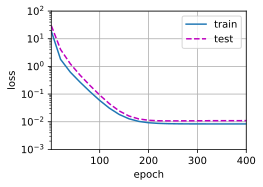

In [9]:
train(poly_features[:n_train,:4],poly_features[n_train:,:4],labels[:n_train],labels[n_train:])

## 欠拟合

weight: [[3.617591  3.4058282]]


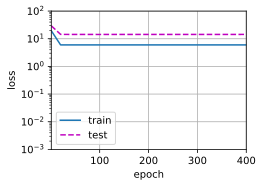

In [10]:
train(poly_features[:n_train,:2],poly_features[n_train:,:2],labels[:n_train],labels[n_train:])